# Baseline implementation
This notebook implement the prediction of hypotension using the last mean artrial pressure (MAP) value. It is use as a baseline to compare with other models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tikzplotlib

from scripts.dataLoader import dataLoaderParallel

In [2]:
HALF_TIME_FILTERING = 5 # secondes
FEATURE_NAME = "dbp"

In [3]:
# test if raw file exists
if not os.path.exists('data/data_async.csv'):
    print('data_async.csv does not exist, please run dataset_download.py first')
    exit()
cols = list(pd.read_csv("data/data_async.csv", nrows=1))

rawData = pd.read_csv(f'data/data_async.csv', usecols =[i for i in cols if i != "opname"] ).astype("float32")


In [4]:
# test if baseline file exists
if not os.path.exists('data/data_baseline.csv'):
    dataframe = dataLoaderParallel(
        half_times= [HALF_TIME_FILTERING],
        signal_name = [FEATURE_NAME],
        sampling_time= 2,
        max_number_of_case= 5000,
        rawData= rawData,
        leading_time= 0,#3*60,
        prediction_windows=60*10
    )
    dataframe.to_csv('data/data_baseline.csv', index=False)
else:
    dataframe = pd.read_csv('data/data_baseline.csv')


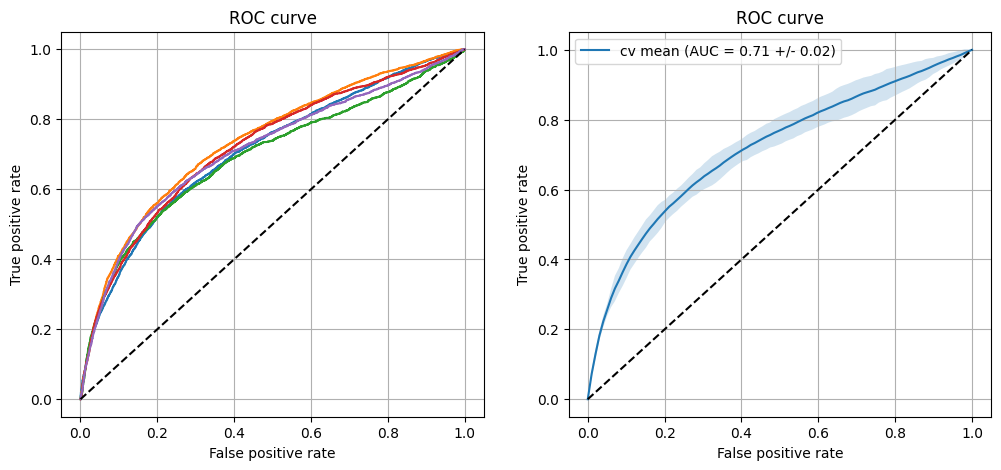

In [5]:
# for each subgoup of data, create a regressor and evaluate it
from sklearn.metrics import auc, roc_curve, roc_auc_score

tpr, fpr, auc  = [], [], []

for cv, test in dataframe.groupby('cv_group'):
    # create a regressor
    test = test.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])

    x_test = test[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test = test['label'].values
    y_pred = 1 - x_test/120

    fpr_, tpr_, _ = roc_curve(y_test, y_pred)
    tpr.append(tpr_)
    fpr.append(fpr_)

    auc.append(roc_auc_score(y_test, y_pred))

# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(len(tpr)):
    plt.plot(fpr[i], tpr[i], label=f'cv {i} (AUC = {auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.grid()

plt.subplot(1, 2, 2)
fpr_mean = np.linspace(0, 1, 100)
tpr_mean = np.zeros(100)
tpr_std = np.zeros(100)
for j in range(len(fpr_mean)):
    tpr_mean[j] = np.mean([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])
    tpr_std[j] = np.std([np.interp(fpr_mean[j], fpr[i], tpr[i]) for i in range(len(tpr))])




plt.fill_between(fpr_mean, tpr_mean - 2*tpr_std, tpr_mean + 2*tpr_std, alpha=0.2)
plt.plot(fpr_mean, tpr_mean, label=f'cv mean (AUC = {np.mean(auc):.2f} +/- {pd.Series(auc).std():.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.grid()
plt.show()

# save data into a csv file
df = pd.DataFrame({
    'fpr': fpr_mean,
    'tpr': tpr_mean,
    'tpr_std': tpr_std,
    'auc': np.mean(auc),
    'auc_std': pd.Series(auc).std(),
})
df.to_csv('data/baseline_roc.csv', index=False)


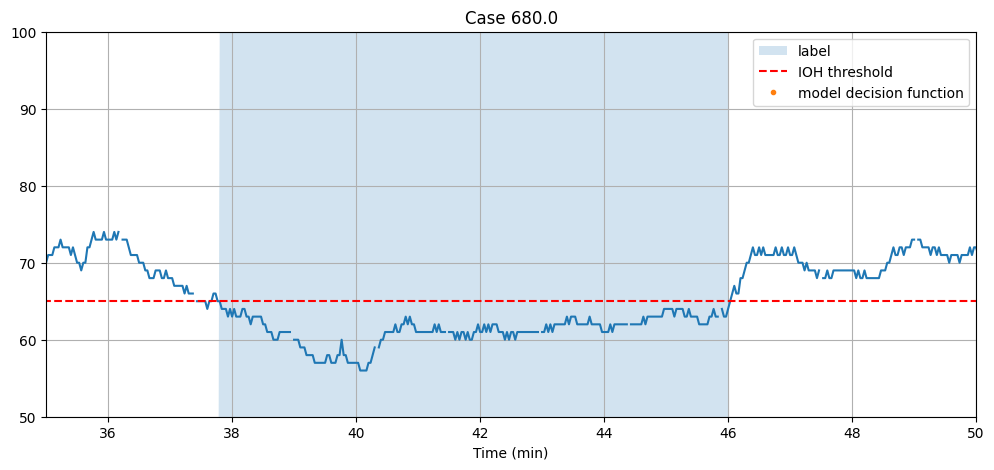

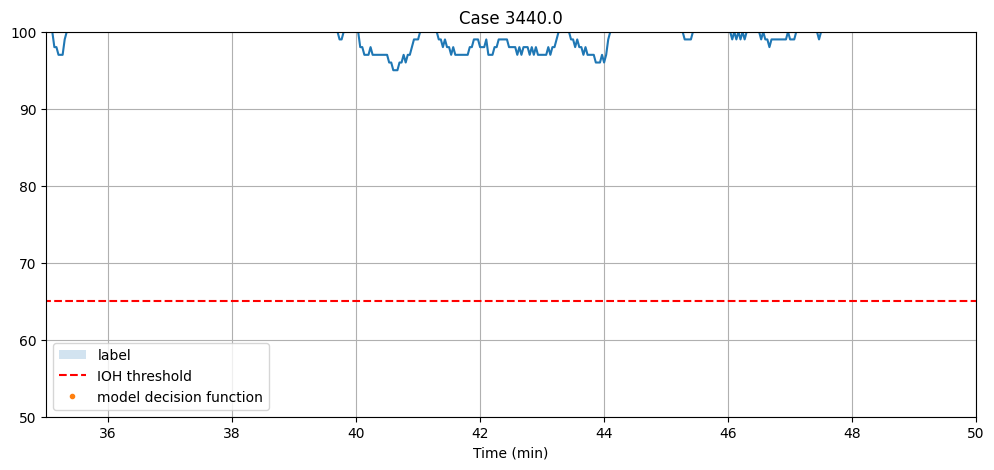

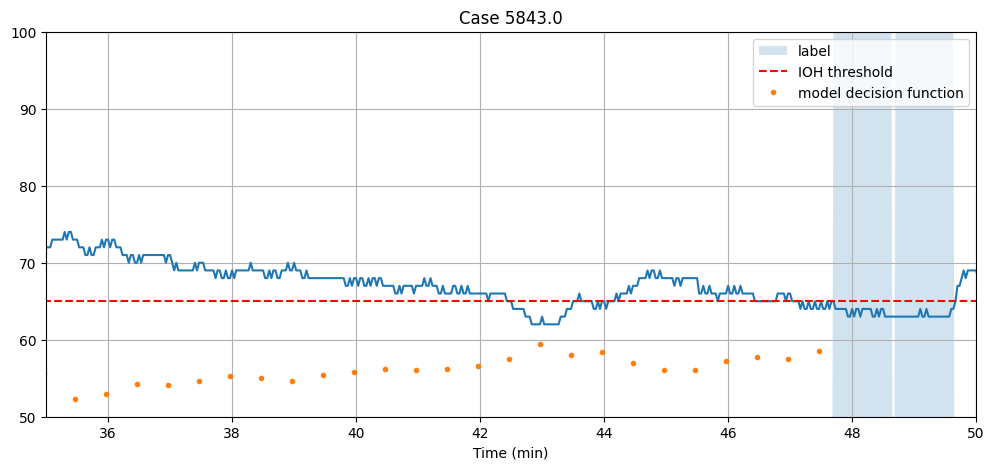

In [19]:
# plot 3 random cases with the corresponding decision function
MIN_TIME_IOH = 60
MIN_VALUE_IOH = 65
def label_caseid(df_case: pd.DataFrame, sampling_time: int):
    """
    Labels the case based on the mean arterial blood pressure (mbp) values.

    Parameters:
    -----------
    df_case : pd.DataFrame 
        The dataframe containing the case data.
    sampling_time : int
        The sampling time in seconds.

    Returns
    -------
    pd.DataFrame: 
        The dataframe with the label column added.
    """
    # create the label for the case
    label = df_case.mbp.rolling(MIN_TIME_IOH//sampling_time,
                                min_periods=1).apply(lambda x: (x < MIN_VALUE_IOH).loc[~np.isnan(x)].all())
    label.fillna(0, inplace=True)
    label = (label + label.shift(-MIN_TIME_IOH//sampling_time , fill_value=0)).astype(bool).astype(int)
    #if label pass from 1 to 0, we keep the 1 for the next MIN_TIME_IOH

    # add label to the data
    df_case.insert(0, 'label', label.astype(int))

    return df_case

np.random.seed(10)
cases = np.random.choice(dataframe['caseid'].unique(), 3, replace=False)

for case in cases:
    raw_case = rawData[rawData.caseid == case].copy()
    raw_case.rename(columns={'Solar8000/ART_MBP': 'mbp'}, inplace=True)
    raw_case.mbp.mask(raw_case.mbp < 40, inplace=True)
    # removing the nan values at the beginning and the ending
    case_valid_mask = ~raw_case.mbp.isna()
    raw_case = raw_case[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]


    raw_case= label_caseid(raw_case, 2)

    segment_data = dataframe[dataframe['caseid'] == case]
    cv_group = segment_data['cv_group'].values[0]


    segment_data = segment_data.dropna(subset=[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'])
    x_test = segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'].values.reshape(-1, 1)
    y_test = segment_data['label'].values
    y_pred = 1 - x_test/120

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case['Time']*2/60, np.zeros(len(raw_case['Time'])), raw_case.label*100, label='label', alpha=0.2)
    plt.plot(raw_case['Time']*2/60, raw_case['mbp'])
    plt.hlines(65, raw_case['Time'].values[0]/60, raw_case['Time'].values[-1]*2/60, color='r', linestyle='--', label='IOH threshold')
    plt.plot(segment_data['time']/60,y_pred*100, '.', label='model decision function')
    # plt.plot(segment_data['time']/60, segment_data[f'{FEATURE_NAME}_ema_{HALF_TIME_FILTERING}'], '*', label='label')
    plt.xlabel('Time (min)')
    plt.xlim([35, 50])
    plt.ylim([50, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()



True

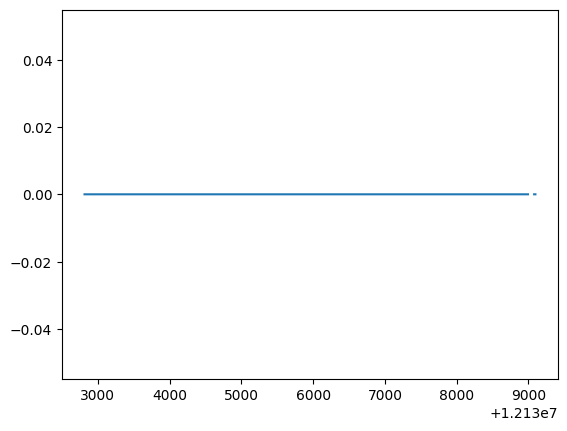

In [9]:

MIN_TIME_IOH = 60
MIN_VALUE_IOH = 65
sampling_time = 2
label1 =  raw_case.mbp.rolling(MIN_TIME_IOH//sampling_time, min_periods=1).apply(lambda x: (x<MIN_VALUE_IOH).loc[~np.isnan(x)].all() if ~x.isna().all() else False) 
label2 =  raw_case.mbp.rolling(MIN_TIME_IOH//sampling_time, min_periods=1).apply(lambda x: (x<MIN_VALUE_IOH).loc[~np.isnan(x)].all())
label2.fillna(0, inplace=True)
label2.astype(int)
label = label1 - label2

label.plot()
seg = raw_case.mbp.iloc[0:30]
~seg.isna().all()

In [8]:
raw_case.mbp

12132813     85.0
12132814     82.0
12132815     80.0
12132816     79.0
12132817     77.0
            ...  
12139093    340.0
12139094     77.0
12139095     77.0
12139096    173.0
12139097    173.0
Name: mbp, Length: 6285, dtype: float32